In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product, permutations

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy
from scipy.stats import mode, entropy, ks_2samp

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import csv
import glob

In [2]:
path = "data"
files = glob.glob(path + "/*.csv")

In [3]:
countries = []

In [4]:
series = []

d = dict()

for filename in tqdm(files, desc="Reading csv"):
    df = pd.read_csv(filename, index_col=None)
    arr = np.array(df.iloc[:,-1])
    if len(arr) == 35136:
        arr = arr.reshape(-1, 4).sum(axis=1)
    if len(arr) == 8784:
        series.append(arr[:2000])
        countries.append(filename[5:-4])

Reading csv:   0%|          | 0/25 [00:00<?, ?it/s]

In [5]:
def normalize(x : np.ndarray):
    return (x - min(x)) / (max(x) - min(x))

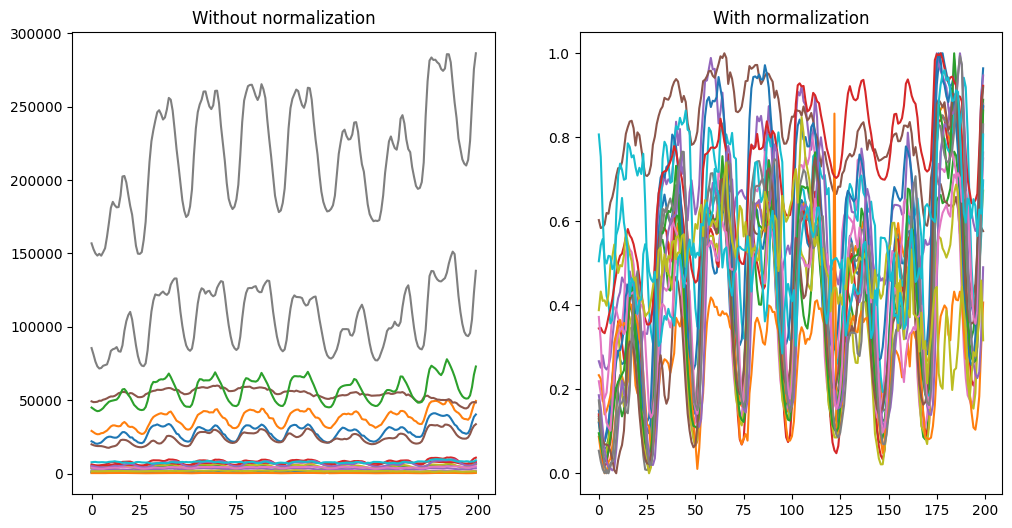

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Without normalization")
for i in series:
    plt.plot(i[:200])

plt.subplot(1, 2, 2)
plt.title("With normalization")
for i, j in zip(series, countries):
    plt.plot(normalize(i)[:200], label=j)
# plt.legend(loc="upper right")
plt.show()

In [70]:
train_points_number = 1000
predicted_points_number = 50
step = 50
M = 10

In [100]:
minmax = [[min(i), max(i)] for i in series]

In [101]:
series_trunc = []
for i in range(len(series)):
    series_trunc.append((series[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0]))

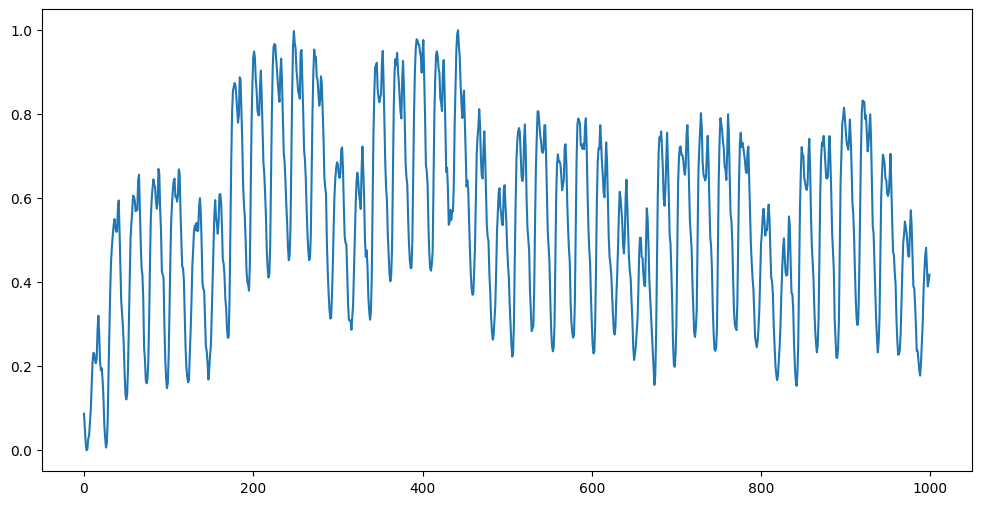

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(series_trunc[1][:1000])
plt.show()

In [102]:
x = series_trunc[0]

In [29]:
# Hyper params
L = 4 # length of pattern
K = 10 # maximal value of pattern element

In [30]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

In [31]:
# Compute motives for train_data vector based on train_points number form point start

def fit(data, train_points_number, start):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc="Fit", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1]):
            vecs.append(data[pattern + j + start])
        z_vectors_list.append(np.array(vecs))
    return z_vectors_list

In [32]:
# Normalizing matrix

def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [33]:
# Predictions on train_data based on motives list by predicted_points_number points
# with max_dist between vectors and maximal allowed MAPE max_mape

def predict(train_data, motives_list, train_points_number, predicted_points_number, max_dist=0.05, max_mape=0.1):
  global patterns

  x_with_predictions = deepcopy(train_data) # copy of train_data with predictions
#   mn, mx = minmax[0]
  for T in tqdm(range(train_points_number, train_points_number + predicted_points_number), desc="Predictions", leave=False):
      St = []
      for i in range(patterns.shape[0]):
          vec = x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]]
          for motive in motives_list:
            normalized_predicted = norm(motive[i][:, :-1] - vec)
            vals = motive[i][(normalized_predicted < max_dist), :][:, -1]
            # vals = vals * (mx - mn) + mn
            St.extend(vals)
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = mode(St, keepdims=True).mode[0]
         # predicted_value = np.mean(St)
      # print(f"Actual: {train_data[T]}, Predicted: {predicted_value}, length: {len(St)}")
      if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
         predicted_value = np.inf
      x_with_predictions[T] = predicted_value
  return x_with_predictions[train_points_number : train_points_number + predicted_points_number]

In [34]:
def calculate_mixed(train_points_number, begin, inds, steps=M):
    actual_vals_matrix = []
    predicted_vals_matrix = []
    
    for i in tqdm(range(steps), "Overall iterations loop", leave=False):
        start = begin + step * i

        motives_list = [fit(series_trunc[i], train_points_number, start) for i in inds]

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict(x, motives_list, start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(steps):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= steps
    unpredicted_points /= steps

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points

In [35]:
def plots(data):
    fig = plt.figure(figsize=(12, 6))
    # fig.suptitle(f"Trained on original series + alike series, train_size={train_points_number}")

    plt.subplot(1, 2, 1)
    plt.title("MAPE, %")
    plt.plot(data[2])

    plt.subplot(1, 2, 2)
    plt.ylim((-0.1, 1.1))
    plt.title("Unpredicted points")
    plt.plot(data[3])

    plt.show()

In [93]:
series_trunc = np.array(series_trunc)

In [37]:
perms = np.array(list(permutations(range(L + 1))))

def calculate_probability_vector(train_data):
    X = fit(train_data, len(train_data), 0)
    counts = {tuple(x) : 0 for x in perms}
    for i in tqdm(range(len(X)), desc="Calculating", leave=False):
        Y = np.argsort(X[i], axis=1)
        for j in Y:
            counts[tuple(j)] += 1
    prob_vec = np.array(list(counts.values())) / sum(counts.values())

    return prob_vec

In [78]:
vecs = pd.read_csv("probability_vectors1.csv", delimiter=';', header=None)

In [83]:
p_vecs = vecs.to_numpy()

In [ ]:
p_vecs = [calculate_probability_vector(i) for i in tqdm(series, desc="Calculating...", leave=False)]

In [39]:
import csv

with open('probability_vectors1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for data in p_vecs:
        writer.writerow(list(map(str, data)))

In [40]:
x_vec = p_vecs[0]

In [41]:
def calculate_entropy_metric(p1, p2):
    return entropy((p1 + p2) / 2) - 0.5 * entropy(p1) - 0.5 * entropy(p2)

In [42]:
s1, s2 = [], []

for i in range(len(p_vecs)):
    vec = p_vecs[i]
    s1.append([np.linalg.norm(np.array(vec) - np.array(x_vec)), i])
    s2.append([calculate_entropy_metric(np.array(vec), np.array(x_vec)), i])
s1_ = sorted(s1)
s2_ = sorted(s2)

In [43]:
y1, y2 = np.zeros((25)), np.zeros((25))

for i in range(len(s1_)):
    y1[s1_[i][1]] = i

for i in range(len(s2_)):
    y2[s2_[i][1]] = i

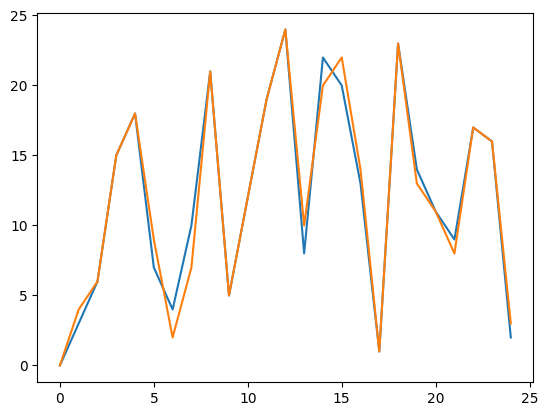

In [46]:
plt.plot(y1)
plt.plot(y2)
plt.show()

In [44]:
places = np.array(y1) + np.array(y2)
places = [i[1] for i in sorted([[places[i], i] for i in range(len(places))])]

In [45]:
print(places)

[0, 17, 24, 6, 1, 9, 2, 5, 7, 21, 13, 20, 10, 16, 19, 3, 23, 22, 4, 11, 8, 14, 15, 18, 12]


In [123]:
places

array([ 0, 17, 24,  1,  6,  9,  2,  5, 13, 21,  7, 20, 10, 16, 19,  3, 23,
       22,  4, 11, 15,  8, 14, 18, 12])

In [94]:
def dtw_distance(series1, series2):
    series1 = np.array(series1).reshape(-1, 1)
    series2 = np.array(series2).reshape(-1, 1)
    distance, _ = fastdtw(series1, series2, dist=euclidean)
    return distance

In [103]:
s3 = []
for j, i in enumerate(series_trunc):
    try:
        s3.append([dtw_distance(x, i), j])
    except:
        print(countries[j])
s3_ = sorted(s3)

poses = [i[1] for i in s3_]

In [104]:
poses

[0, 3, 1, 17, 10, 15, 19, 8, 16, 7, 12, 9, 4, 14, 2, 13, 6, 18, 5, 11]

In [124]:
with open('series_positions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(list(map(str, places)))

In [ ]:
data_1 = calculate_mixed(train_points_number, 0, [0, 3], steps=20)

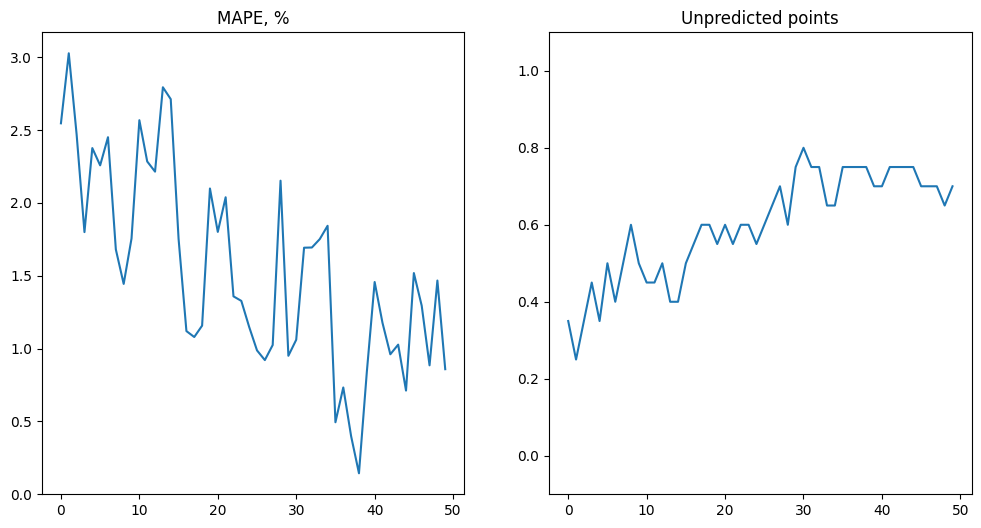

In [106]:
plots(data_1)

In [107]:
print(np.mean(data_1[3]))

0.598


Trained on original

In [ ]:
data0 = calculate_mixed(train_points_number, 0, [places[0]], steps=20)

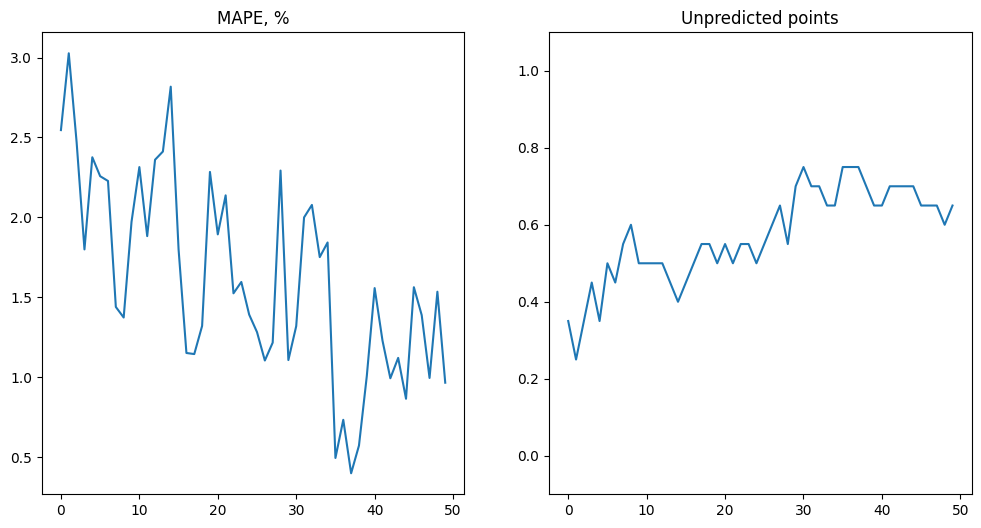

In [126]:
plots(data0)

In [127]:
print(np.mean(data0[3]))

0.573


Mixing 1

In [ ]:
data1 = calculate_mixed(train_points_number, 0, [places[0], places[1]], steps=20)

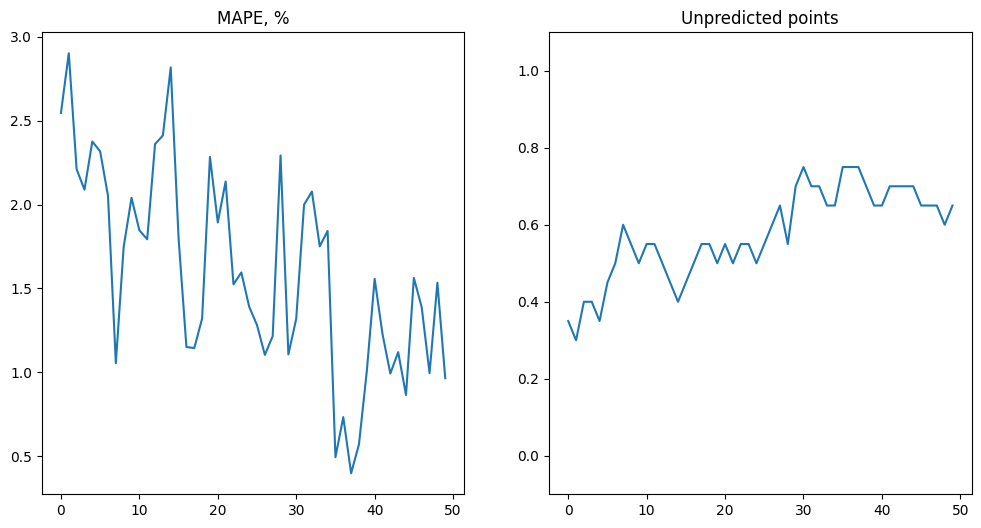

In [129]:
plots(data1)

In [130]:
print(np.mean(data1[3]))

0.5760000000000001


Mixing 2

In [ ]:
data2 = calculate_mixed(train_points_number, 0, [places[0], places[2]], steps=20)

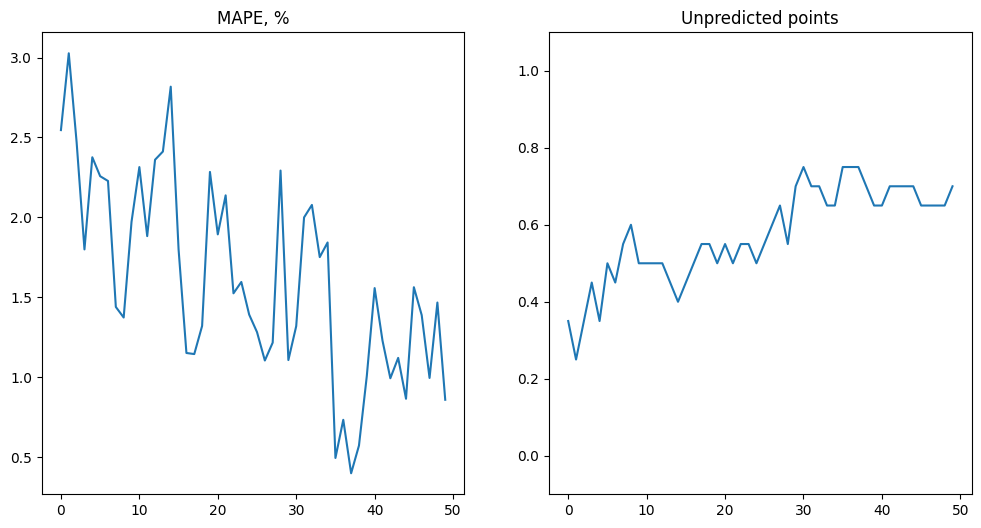

In [132]:
plots(data2)

In [133]:
print(np.mean(data2[3]))

0.575


Mixing 3

In [ ]:
data3 = calculate_mixed(train_points_number, 0, [places[0], places[3]], steps=20)

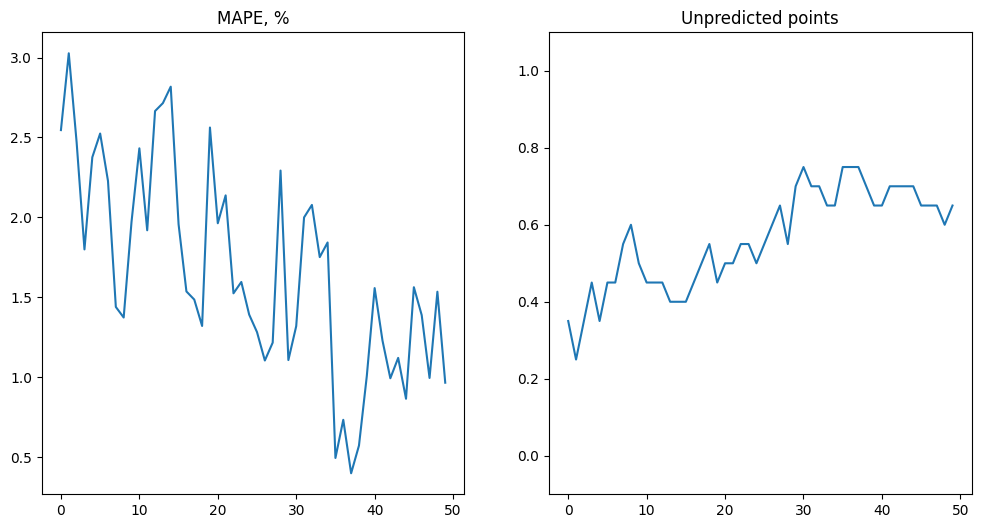

In [135]:
plots(data3)

In [136]:
print(np.mean(data3[3]))

0.563


Mixing 4

In [ ]:
data4 = calculate_mixed(train_points_number, 0, [places[0], places[4]], steps=20)

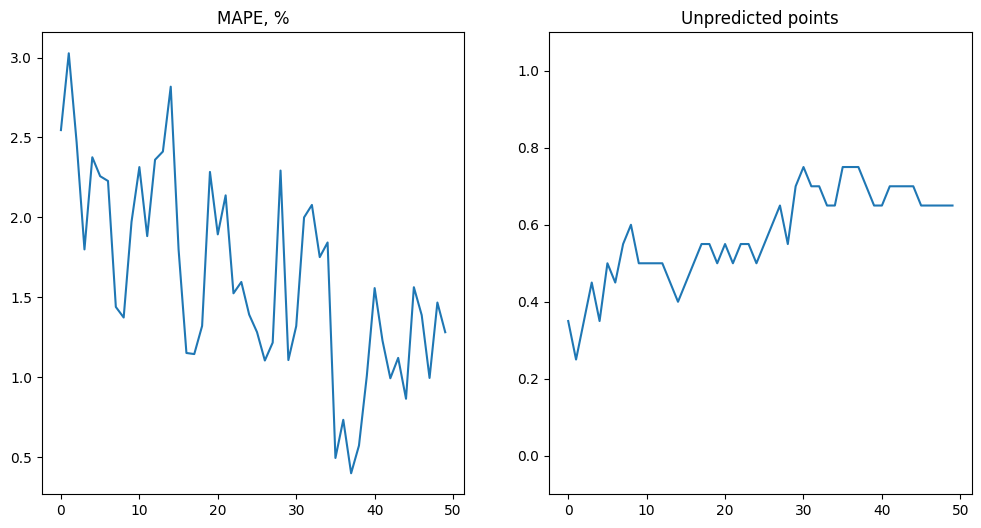

In [138]:
plots(data4)

In [139]:
print(np.mean(data4[3]))

0.574


Mixing 5

In [ ]:
data5 = calculate_mixed(train_points_number, 0, [places[0], places[5]], steps=20)

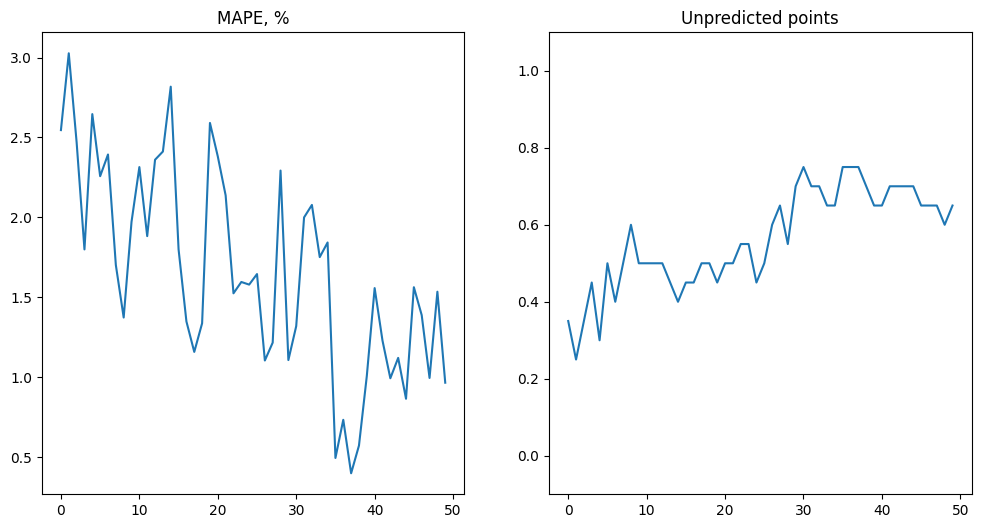

In [141]:
plots(data5)

In [142]:
print(np.mean(data5[3]))

0.563


Mixing 6

In [ ]:
data6 = calculate_mixed(train_points_number, 0, [places[0], places[3], places[4]], steps=20)

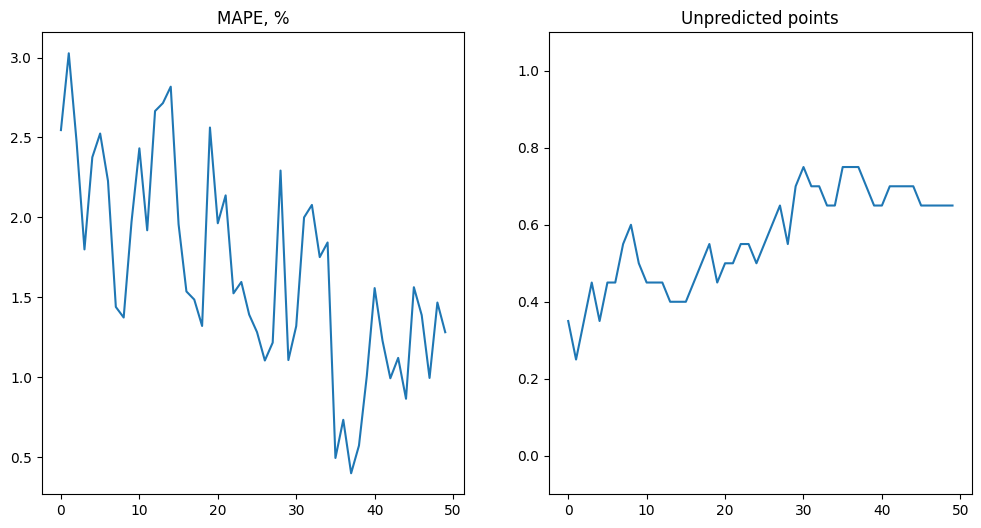

In [144]:
plots(data6)

In [145]:
print(np.mean(data6[3]))

0.564


Mixing 7

In [ ]:
data7 = calculate_mixed(train_points_number, 0, [places[0], places[3], places[5]], steps=20)

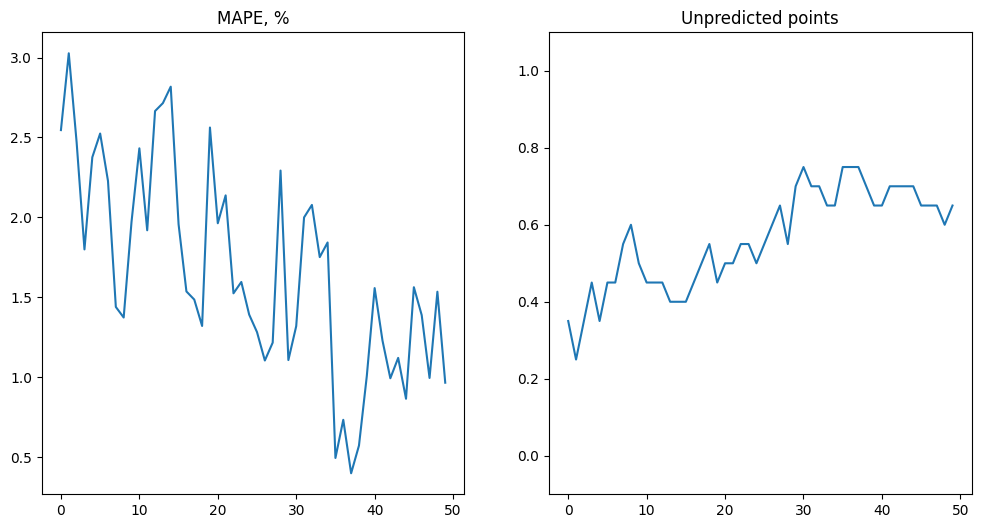

In [147]:
plots(data7)

In [148]:
print(np.mean(data7[3]))

0.563


Mixing 8

In [ ]:
data8 = calculate_mixed(train_points_number, 0, [places[0], places[4], places[5]], steps=20)

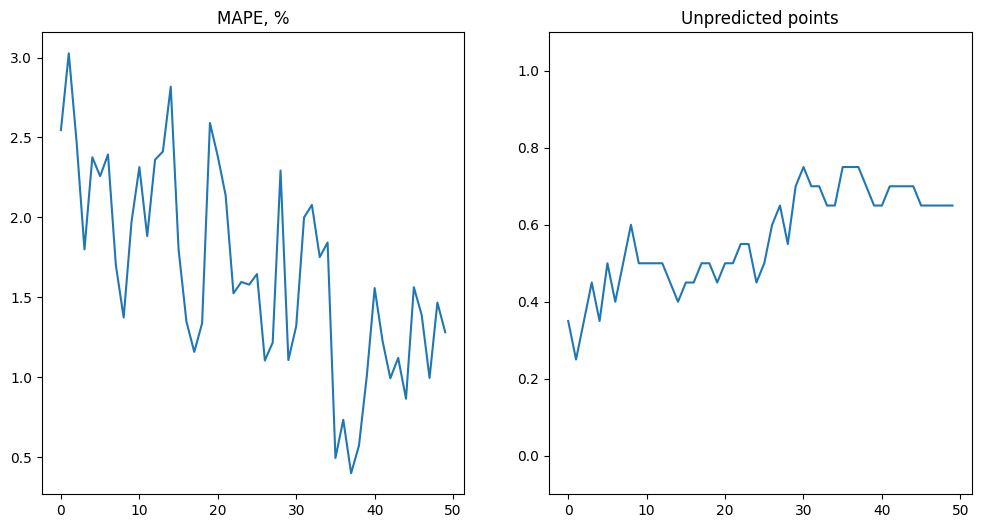

In [163]:
plots(data8)

In [164]:
print(np.mean(data8[3]))

0.5649999999999998


In [151]:
from scipy.interpolate import make_interp_spline

def make_smooth_plot(y, label):
    y = np.array(y)
    x = np.arange(y.shape[0])
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 1000)
    Y_ = X_Y_Spline(X_)
    plt.plot(X_, Y_, label=label)

In [165]:
DATA = [data0, data1, data2, data3, data4, data5, data6, data7, data8]

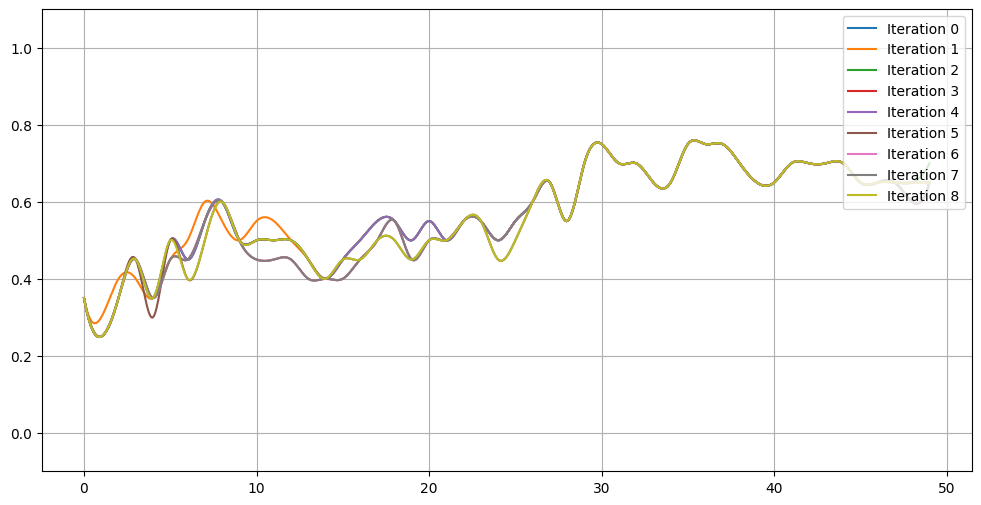

In [171]:
plt.figure(figsize=(12, 6))
for j, i in enumerate(DATA):
    # make_smooth_plot(i[3], label=f"Iteration {j}")
    make_smooth_plot(i[3], label=f"Iteration {j}")
plt.ylim((-0.1, 1.1))
plt.legend(loc="upper right")
plt.grid()
plt.show()

To csv

In [111]:
import csv

with open('consumption11.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i, data in enumerate([data_1]):
        writer.writerow(list(map(str, data[2])))
        writer.writerow(list(map(str, data[3])))